# Pengambilan Data

In [81]:
# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from google.auth import default
# creds, _ = default()

# gc = gspread.authorize(creds)

# spreadsheet_key = '1YIx7fOnN8Ou3UlBvrQzlfIaprJ12lDEPgYzmW2C_Gnc'
# worksheet_name = 'Sheet1'

# # untuk membuka spreadsheet
# sh = gc.open_by_key(spreadsheet_key)
# worksheet = sh.worksheet(worksheet_name)
# ambil semua data dari spreadsheet
# data = worksheet.get_all_values()

# Konversi data ke dataframe
import pandas as pd
data = pd.read_csv(r'F:\ColleagueFakhri\Penggalian Data dan Perolehan Informasi\UAS\dataset\DataIntiSawitFossNirs.csv')
print(data.head());
# df = pd.DataFrame(data[1:], columns=data[0]) #Kolom Pertama Sebagai Header

# print(df.head())

  COMPANY PKS_CODE  INSTRUMENT_SERIAL_NUMBER  OIL_WM    VM  OIL_DM    NOS  \
0    N00D     DP03                       NaN   38.06  7.43   41.11  54.51   
1    N00D     DP03                       NaN   38.75  5.88   41.18  55.36   
2    N00D     DP03                       NaN   40.21  3.73   41.77  56.06   
3    N006     FP03                       NaN   52.73  4.83   55.41  42.44   
4  [NULL]     7F08                       NaN   40.93  4.09   42.68  54.98   

    FFA  DOBI  RILL_MUTU_KADAR_AIR INC_MUTU_KADAR_AIR  
0  1.18     0                 7.43                red  
1  0.55     0                 5.88              green  
2  0.00     0                 3.73              green  
3  0.00     0                 4.83              green  
4  0.00     0                 4.09             orange  


In [82]:
#Mengambil kolom tertentu
selected_columns = [
    'OIL_WM',
    'VM',
    'OIL_DM',
    'NOS',
    'FFA',
];

data_raw = data[selected_columns].copy()

#perubahan alias nama, nama asal dari mesin
new_column_names = {
    'OIL_WM': 'OilWetMatter',
    'VM': 'VolatileMatter',
    'OIL_DM': 'OilDryMatter',
    'NOS': 'NonOilSolids',
    'FFA': 'FreeFattyAcid'
}

#Mengubah nama kode
data_raw = data_raw.rename(columns=new_column_names)

#Mengkonversi bilangan ke numerik
data_raw = data_raw.apply(pd.to_numeric, errors='coerce')

data_raw.head()

,OilWetMatter,VolatileMatter,OilDryMatter,NonOilSolids,FreeFattyAcid
0,38.06,7.43,41.11,54.51,1.18
1,38.75,5.88,41.18,55.36,0.55
2,40.21,3.73,41.77,56.06,0.00
3,52.73,4.83,55.41,42.44,0.00
4,40.93,4.09,42.68,54.98,0.00


In [83]:
# Menghapus baris dengan nilai NaN setelah konversi
data_raw = data_raw.dropna()

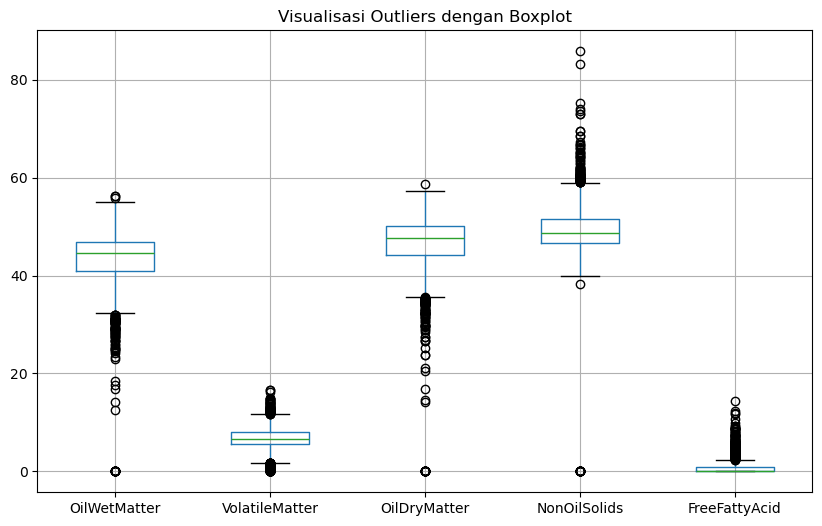

In [84]:
import matplotlib.pyplot as plt

# Visualisasi Outliers menggunakan Boxplot
plt.figure(figsize=(10, 6))
data_raw.boxplot()
plt.title("Visualisasi Outliers dengan Boxplot")
plt.show()

In [85]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Deteksi Outlier Menggunakan IsolationForest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(data_raw)

# Ambil inliers
data_inliers = data_raw[outlier_labels == 1]

In [86]:
data_inliers.head()

,OilWetMatter,VolatileMatter,OilDryMatter,NonOilSolids,FreeFattyAcid
0,38.06,7.43,41.11,54.51,1.18
1,38.75,5.88,41.18,55.36,0.55
2,40.21,3.73,41.77,56.06,0.00
3,52.73,4.83,55.41,42.44,0.00
4,40.93,4.09,42.68,54.98,0.00


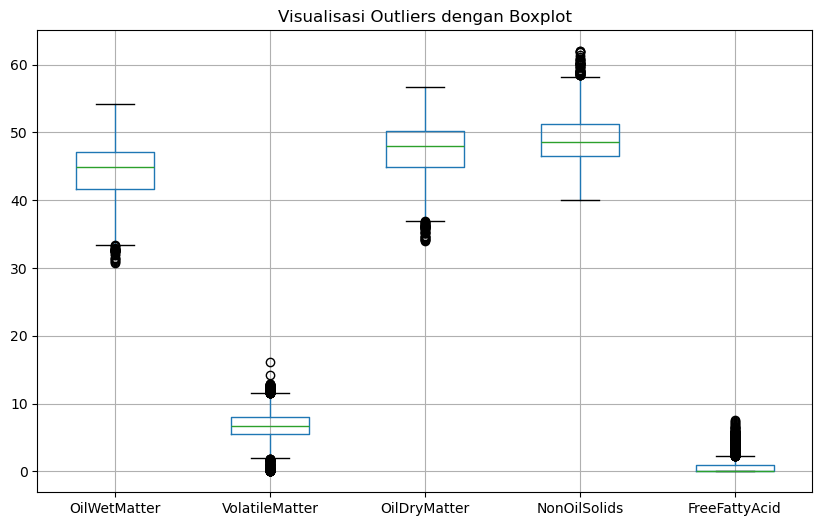

In [87]:
# Visualisasi Outliers menggunakan Boxplot
plt.figure(figsize=(10, 6))
data_inliers.boxplot()
plt.title("Visualisasi Outliers dengan Boxplot")
plt.show()

In [88]:
#Normalisasi
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_inliers)

In [89]:
#Menggunakan PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_normalized)

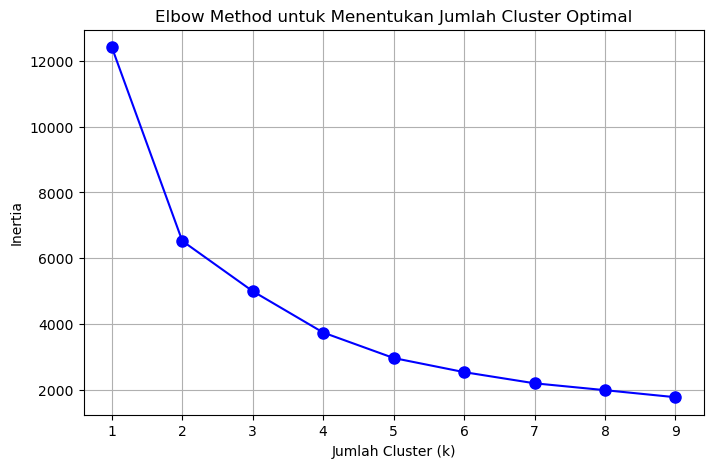

In [90]:
#Menggunakan Elbow Method untuk mencari nilai K
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

# Visualisasi
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
plt.grid(True)
plt.show()

C:\Users\Fakhri Andika\AppData\Local\Temp\ipykernel_24840\1028040223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_inliers['Cluster'] = kmeans.fit_predict(data_pca)


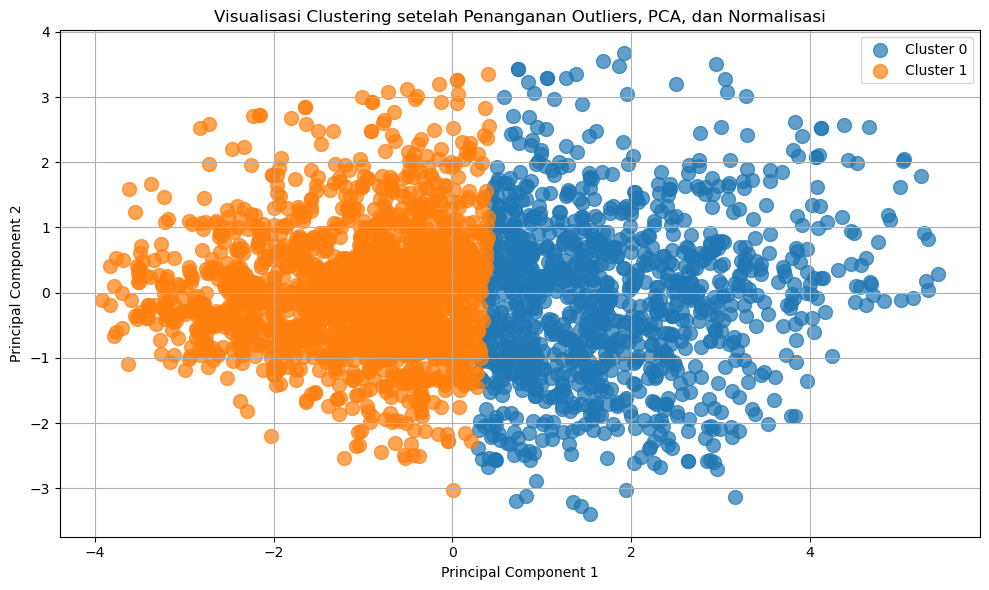

In [91]:
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_inliers['Cluster'] = kmeans.fit_predict(data_pca)

#Visualisasi Cluster
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(data_pca[data_inliers['Cluster'] == cluster, 0],
                data_pca[data_inliers['Cluster'] == cluster, 1],
                label=f'Cluster {cluster}', alpha=0.7, s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Visualisasi Clustering setelah Penanganan Outliers, PCA, dan Normalisasi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Fakhri Andika\AppData\Local\Temp\ipykernel_24840\1931085731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_inliers['Cluster'] = kmeans.fit_predict(data_pca)


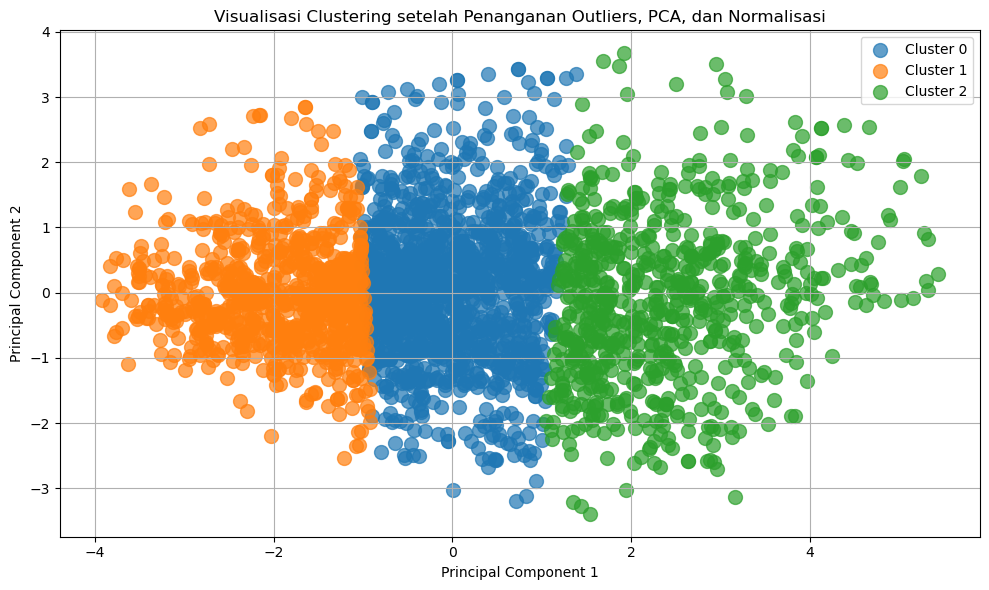

In [92]:
#Mencoba K = 3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_inliers['Cluster'] = kmeans.fit_predict(data_pca)

#Visualisasi Cluster
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(data_pca[data_inliers['Cluster'] == cluster, 0],
                data_pca[data_inliers['Cluster'] == cluster, 1],
                label=f'Cluster {cluster}', alpha=0.7, s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Visualisasi Clustering setelah Penanganan Outliers, PCA, dan Normalisasi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
# Cluster summary
cluster_summary = data_inliers.groupby('Cluster').mean()

# Displaying the summary for the user
print("Ringkasan Cluster:")
print(cluster_summary)

Ringkasan Cluster:
         OilWetMatter  VolatileMatter  OilDryMatter  NonOilSolids  \
Cluster                                                             
0           44.462825        6.516084     47.567127     49.021188   
1           48.850831        6.091848     52.021097     45.057448   
2           38.412603        7.965205     41.745671     53.621863   

         FreeFattyAcid  
Cluster                 
0             0.740974  
1             0.289607  
2             1.107589  


In [94]:
data_inliers1 = data_inliers
df= data_inliers1.copy()
print(df)

      OilWetMatter  VolatileMatter  OilDryMatter  NonOilSolids  FreeFattyAcid  \
0            38.06            7.43         41.11         54.51           1.18   
1            38.75            5.88         41.18         55.36           0.55   
2            40.21            3.73         41.77         56.06           0.00   
3            52.73            4.83         55.41         42.44           0.00   
4            40.93            4.09         42.68         54.98           0.00   
...            ...             ...           ...           ...            ...   
3200         41.12            4.58         43.10         54.30           0.00   
3201         46.30            2.62         47.55         51.08           0.00   
3202         45.35            5.01         47.74         49.64           0.70   
3203         38.66            8.19         42.11         53.15           3.68   
3204         50.35            5.80         53.45         43.86           0.00   

      Cluster  
0          

In [95]:
# Pastikan Anda sudah menggabungkan data asli dengan cluster hasil KMeans
# Jika kolom `pks_code` berada di data asli, tambahkan kolom ini ke data_inliers
df['pks_code'] = data['PKS_CODE']

# Hitung jumlah setiap pks_code dalam setiap cluster
cluster_counts = df.groupby(['Cluster', 'pks_code']).size().reset_index(name='count')

# # Hitung total jumlah data dalam setiap cluster
# cluster_totals = df.groupby('Cluster').size().reset_index(name='total')

# # Gabungkan data cluster_counts dengan cluster_totals
# cluster_counts = cluster_counts.merge(cluster_totals, on='Cluster')

# # Hitung persentase kontribusi setiap pks_code dalam setiap cluster
# cluster_counts['percentage'] = (cluster_counts['count'] / cluster_counts['total']) * 100

# Tampilkan hasil
print(df)

# Jika ingin menyimpan hasil ke file CSV
# cluster_counts.to_csv('ClusterPercentage.csv', index=False)


      OilWetMatter  VolatileMatter  OilDryMatter  NonOilSolids  FreeFattyAcid  \
0            38.06            7.43         41.11         54.51           1.18   
1            38.75            5.88         41.18         55.36           0.55   
2            40.21            3.73         41.77         56.06           0.00   
3            52.73            4.83         55.41         42.44           0.00   
4            40.93            4.09         42.68         54.98           0.00   
...            ...             ...           ...           ...            ...   
3200         41.12            4.58         43.10         54.30           0.00   
3201         46.30            2.62         47.55         51.08           0.00   
3202         45.35            5.01         47.74         49.64           0.70   
3203         38.66            8.19         42.11         53.15           3.68   
3204         50.35            5.80         53.45         43.86           0.00   

      Cluster pks_code  
0 

In [96]:
# Hitung ulang tabel pivot
if 'pks_code' in df.columns and 'Cluster' in df.columns:
    # Hitung total data per PKS_CODE
    total_per_pks = df.groupby('pks_code').size()
    
    # Hitung jumlah data per cluster untuk setiap PKS_CODE
    cluster_counts = df.groupby(['pks_code', 'Cluster']).size()
    
    # Hitung persentase per cluster dalam setiap PKS_CODE
    cluster_percentages = (cluster_counts / total_per_pks) * 100

    # Buat tabel pivot dengan PKS_CODE sebagai index dan Cluster sebagai kolom
    pivot_table = cluster_percentages.unstack(fill_value=0)
    
    # Ekspor tabel pivot ke file CSV
    output_file_path = 'F:/ColleagueFakhri/Penggalian Data dan Perolehan Informasi/UAS/dataset/Cluster_Percentages_By_PKS_CODE.csv'
    pivot_table.to_csv(output_file_path, index=True)
    
    print(pivot_table);
else:
    "Kolom 'PKS_CODE' dan/atau 'Cluster' tidak ditemukan dalam dataset."
    print("Kolom 'PKS_CODE' dan/atau 'Cluster' tidak ditemukan dalam dataset.");



Cluster            0           1           2
pks_code                                    
7F06       67.901235   17.283951   14.814815
7F07       31.944444    2.777778   65.277778
7F08       71.171171    7.207207   21.621622
AP06       60.000000    0.000000   40.000000
CP01       83.333333    0.000000   16.666667
CP02       48.333333   11.111111   40.555556
CP03       73.267327   25.742574    0.990099
CP09       55.319149   24.758221   19.922631
CP10       60.000000   40.000000    0.000000
DP02       66.355140    9.345794   24.299065
DP03        0.000000    0.000000  100.000000
DP04       75.000000    0.000000   25.000000
DP09       50.000000   50.000000    0.000000
DP11       11.111111    0.000000   88.888889
DP13       77.777778    0.000000   22.222222
DP14       72.222222    2.222222   25.555556
DP15       14.285714    0.000000   85.714286
DP16       86.666667    6.666667    6.666667
DP17       55.555556   22.222222   22.222222
DP18       86.666667    0.000000   13.333333
EP02      

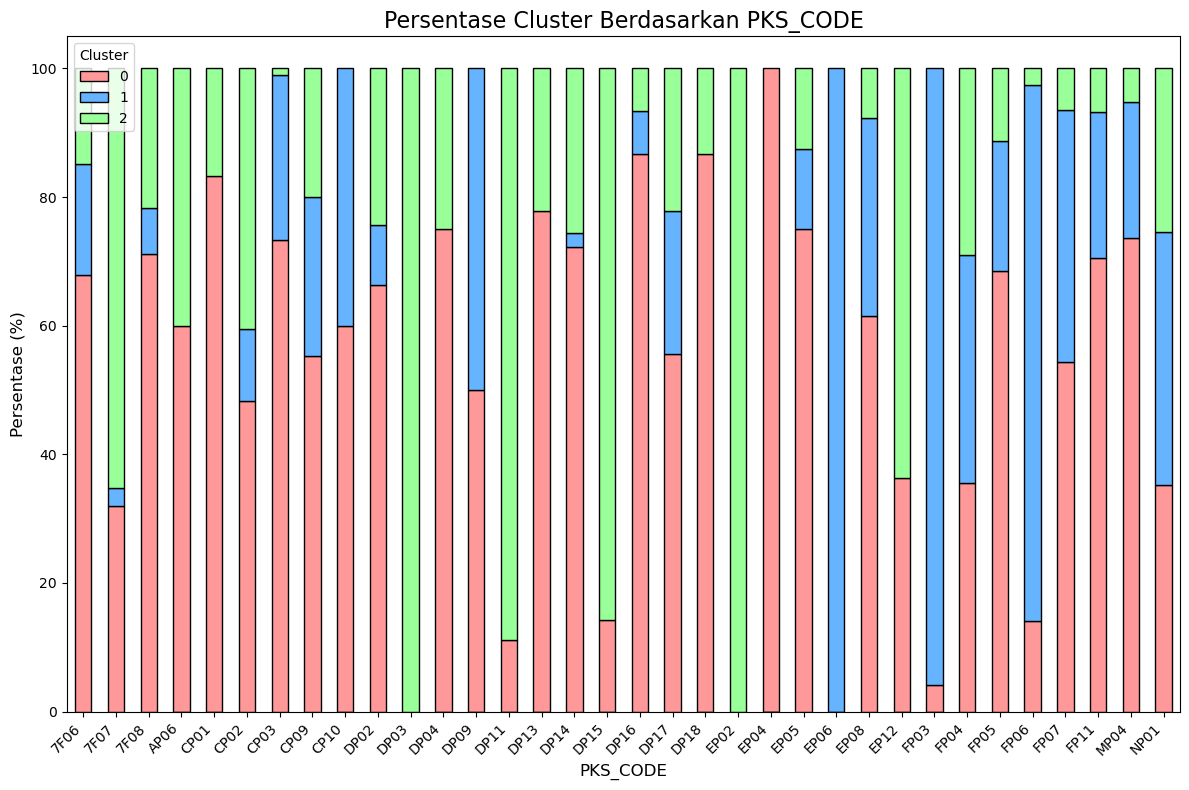

In [97]:
import matplotlib.pyplot as plt

# Membuat stacked bar chart dari tabel pivot
pivot_table.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=['#ff9999', '#66b3ff', '#99ff99'],
    edgecolor='black'
)

# Menambahkan label dan judul
plt.title('Persentase Cluster Berdasarkan PKS_CODE', fontsize=16)
plt.xlabel('PKS_CODE', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Tampilkan plot
plt.show()
